In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import readdy

## Setup ReaDDy system

In [2]:
system = readdy.ReactionDiffusionSystem(
    box_size=[0.3, 0.3, 0.3],
    unit_system={"length_unit": "micrometer", "time_unit": "second"}
)

system.add_species("E", diffusion_constant=10.)
system.add_species("S", diffusion_constant=10.)
system.add_species("ES", diffusion_constant=10.)
system.add_species("P", diffusion_constant=10.)

system.reactions.add("fwd: E +(0.01) S -> ES", rate=86.78638438)
system.reactions.add("back: ES -> E +(0.01) S", rate=1.)
system.reactions.add("prod: ES -> E +(0.01) P", rate=1.)

## Simulate the system

In [3]:
simulation = system.simulation(kernel="CPU")
simulation.output_file = "out.h5"
simulation.reaction_handler = "UncontrolledApproximation"

n_particles_e = 909
n_particles_s = 9091
edge_length = system.box_size[0]
initial_positions_e = np.random.random(size=(n_particles_e, 3)) * edge_length - .5*edge_length
initial_positions_s = np.random.random(size=(n_particles_s, 3)) * edge_length - .5*edge_length
simulation.add_particles("E", initial_positions_e)
simulation.add_particles("S", initial_positions_s)

simulation.observe.number_of_particles(stride=1, types=["E", "S", "ES", "P"])

In [4]:
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

dt = 1e-4
n_steps = int(1. / dt)
print('nsteps={}'.format(n_steps))

nsteps=10000


In [5]:
#simulation.skin = 30
simulation.run(n_steps=n_steps, timestep=dt)

Box(children=(Text(value=''), IntProgress(value=0)))

In [6]:
traj = readdy.Trajectory(simulation.output_file)
time, counts = traj.read_observable_number_of_particles()

In [7]:
counts.shape

(10001, 4)

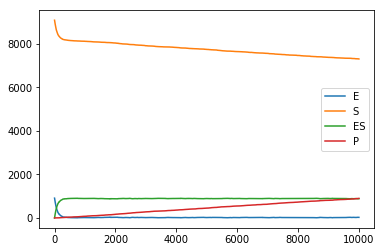

In [8]:
plt.plot(time, counts[:,0], label='E')
plt.plot(time, counts[:,1], label='S')
plt.plot(time, counts[:,2], label='ES')
plt.plot(time, counts[:,3], label='P')
plt.legend()
plt.show()